<a href="https://colab.research.google.com/github/Shibli-Nomani/Secured-AI-Agents-with-Privacy-and-Saftey-Filters/blob/main/Secured_AI_Agents_with_Privacy_and_Safety_Filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💡 Secured AI Agents with Privacy & Safety Filters

💡 Project Summary: This AI messaging pipeline uses 🛡️ Privacy-Filter, ☠️🔞 Content Moderation, and 🧠 LLM Summarization to sanitize, flag, and summarize messages while logging all actions for traceability.

🚀 Importance: Ensures safe, private, and compliant communication in AI agents, enabling trustworthy interactions, ethical handling of PII, and concise insights from messy inputs.

**💀 Disclaimer: You may encounter abusive, adult, or toxic sentences here. These are for testing purposes only, and any names mentioned are imaginary. If someone happens to have the same name, please do not take offense. Nothing here is related to real individuals.**

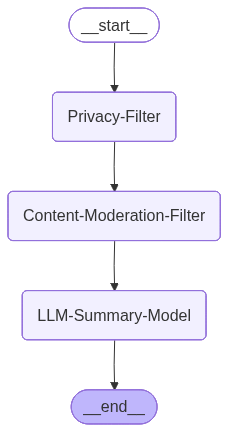



**🔊 Workflow**
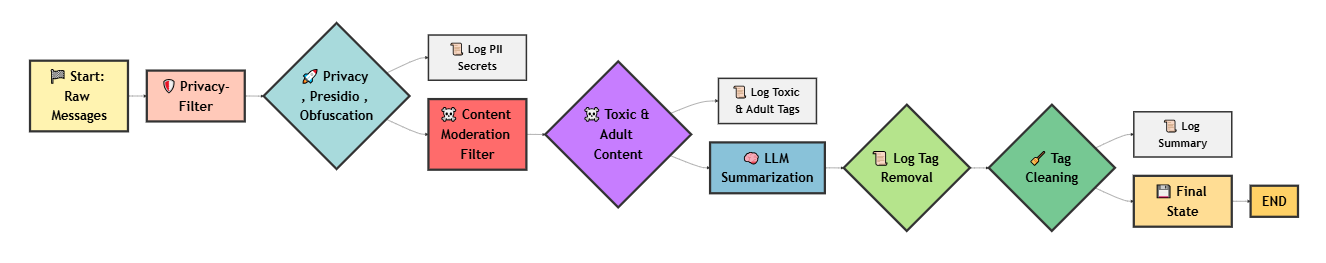

# ❄️ Import Libraries

In [ ]:
# === Install Required Packages ===

!pip install Langchain Langgraph Langsmith Langchain-groq Langchain_community chromadb

In [ ]:
# === Install Required Packages ===
!pip install presidio-analyzer presidio-anonymizer

In [ ]:
# === Install Required Packages ===
!pip install rapidfuzz

In [ ]:
# === ipywidgets ===
#!pip install --upgrade notebook ipywidgets


note: Censor Chat-https://github.com/qiuhuachuan/CensorChat

In [4]:
# ===========================
# Standard Library Imports
# ===========================
import os                           # OS operations
import re                           # Regex handling
import json                         # JSON parsing
import uuid                         # UUID generation
import time                         # Time-related functions
import math                         # Mathematical operations
import copy                         # Object copying
import hmac                         # Cryptographic signing
import hashlib                      # Hashing utilities
import secrets                      # Secure random numbers
import traceback                    # Tracebacks for debugging
import logging                      # Logging
import warnings                     # Suppress warnings
from collections import Counter     # Counting hashable items
from datetime import datetime       # Date & time utils
from typing import Dict, Any, TypedDict, Annotated, List  # Type hinting

# ===========================
# LangChain & LangGraph
# ===========================
from langchain_groq import ChatGroq                                  # Groq model
from langchain_core.prompts import PromptTemplate                    # Prompt formatting
from langchain_core.output_parsers import StrOutputParser            # Output parsing
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage  # Message types
from langchain.schema import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END                   # LangGraph structure
from langgraph.graph.message import add_messages                     # Message handling
from langgraph.checkpoint.memory import MemorySaver                  # Checkpointing
from langgraph.prebuilt import ToolNode, tools_condition             # Prebuilt tools

# ===========================
# ChromaDB
# ===========================
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings

# ===========================
# Transformers & Torch
# ===========================
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# ===========================
# Presidio for PII Detection
# ===========================
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine, OperatorConfig

# ===========================
# Other NLP / Utility Libraries
# ===========================
from rapidfuzz import fuzz  # String similarity scoring

# ===========================
# Jupyter / Display Tools
# ===========================
from IPython.display import Image, display  # For graph rendering in notebooks

# ===========================
# Warning & Logging Control
# ===========================
warnings.filterwarnings("ignore")  # Suppress all warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("presidio-analyzer").setLevel(logging.ERROR)


# 🔑 API Integration

- ⚡ LLM Model from Groq for Summarization


In [5]:
#API key
groq_api_key="your groq API key here"
#Initialize Groq LLM with gpt oss model
llm = ChatGroq(model="openai/gpt-oss-20b", groq_api_key=groq_api_key)

# 👀 Create State
- 🗂️ State – Tracks conversation data: messages, IDs, logs, and content flags (adult/toxic).

In [6]:
# Define State
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    conversation_id: str
    logs: List[str]
    adult_tag_index: int
    toxic_tag_index: int

# 🛡️ Utility Functions

- 🔑 HMAC Key – Securely convert sensitive data into safe, repeatable tokens.

- ⚡ Load/Generate Key – Get the key from environment or create a temporary one.
- 🔒 Deterministic Hash – Turn secrets into irreversible, repeatable tokens.
- 📊 Entropy – Measure randomness of a string to detect complex secrets.
- 🔍 Secret Detection – Identify strings that look like passwords or random keys.

`HMAC_KEY = b"change_this_secret_key"`


In [7]:
# HMAC key for deterministic hashing
# -------------------------------
# Load HMAC key from environment
# -------------------------------
# -------------------------------
# Utility functions
# -------------------------------
# It’s a secret key used to convert sensitive data (emails, passwords, API keys) into secure tokens.
# ensures you can store data in your database without keeping raw secrets, while still recognizing repeated secrets
# Try to load key from environment
# Load or generate key
HMAC_KEY = os.environ.get("PRIVACY_HMAC_KEY")
if not HMAC_KEY:
    HMAC_KEY = secrets.token_hex(32)  # 64 hex chars
    print("PRIVACY_HMAC_KEY not found. Using temporary key for this session.")
else:
    print("Loaded PRIVACY_HMAC_KEY from environment.")

HMAC_KEY = HMAC_KEY.encode()

# --- Deterministic hash function for emails/phones ---
def deterministic_hash(value: str) -> str:
    """Generate a deterministic, irreversible token for a secret."""
    value = value.strip().lower()  # normalize input
    return hmac.new(HMAC_KEY, value.encode(), hashlib.sha256).hexdigest()[:16]  # 16 chars token

# --- Entropy and heuristic ---
def entropy(s: str) -> float:
    """Approximate Shannon entropy of a string."""
    if not s:
        return 0.0
    counts = Counter(s)
    probs = [count / len(s) for count in counts.values()]
    return -sum(p * math.log2(p) for p in probs)

def looks_like_secret(s: str) -> bool:
    """Detect secret-like strings: short passwords or random keys."""
    return len(s) >= 8 and entropy(s) > 3.25

PRIVACY_HMAC_KEY not found. Using temporary key for this session.


#  1️⃣ Privacy Filter Node

🛡️ PrivacyFilter – Main node to sanitize and protect conversation text.

🔍 PII Detection – Detects and anonymizes emails, phone numbers, and other Presidio-supported sensitive data. Add deteministic Token for Email and Phone. Same email and phone have same token for multiple appearance. Token is irreversable. ` [TOKEN:ab12cd34ef56...] using deterministic_hash`

⚡ High-Entropy Secrets – Flags strings that look like passwords, tokens, or API keys.

📝 Obfuscation Filter – Replaces offensive or obfuscated words using leetspeak normalization, homoglyphs, and fuzzy matching.

📜 Logging – Records all executed filters, replacements, and anonymizations for traceability.

In [8]:

# -------------------------------
# Privacy Filter Node
# -------------------------------

class PrivacyFilter:
    """
    Provides methods to sanitize and filter text for privacy and safety:
    - Detects/anonymizes PII (phones, emails, Presidio entities).
    - Flags high-entropy secrets (API keys, tokens).
    - Detects obfuscated/offensive words (leet, homoglyphs, fuzzy matches).
    """
    def __call__(self, state: dict) -> dict:
        """Default behavior when used as a LangChain node."""
        state = self.privacy_pipeline_filter_mode(state)
        state = self.obfuscation_filter_mode(state)
        return state
    # -------------------------
    # SubNode: Privacy Filter PII
    # -------------------------
    @staticmethod
    def privacy_pipeline_filter_mode(state: State) -> State:
        """
        Detects/anonymizes phones, emails, other PII via Presidio,
        and flags high-entropy secrets.
        """
        messages = state.get("messages", [])
        if not messages:
            return state

        last_msg = messages[-1]
        if not hasattr(last_msg, "content"):
            return state

        text = last_msg.content
        executed_keywords = []

        # --- Step 1: Phone numbers ---
        phone_pattern = re.compile(r'\b\d{3,4}[-.]?\d{6,10}\b')

        def phone_replace(match):
            executed_keywords.append("phones")
            token = deterministic_hash(match.group(0))
            return f"[TRACKER:PHONE:{token}]"

        text = phone_pattern.sub(phone_replace, text)

        # --- Step 2: Emails ---
        email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')

        def email_replace(match):
            executed_keywords.append("emails")
            token = deterministic_hash(match.group(0))
            return f"[TRACKER:EMAIL:{token}]"

        text = email_pattern.sub(email_replace, text)

        # --- Step 3: Presidio PII ---
        try:
            analyzer = AnalyzerEngine()
            anonymizer = AnonymizerEngine()

            results = analyzer.analyze(text=text, language="en")
            filtered_results = [r for r in results if r.entity_type not in ("EMAIL_ADDRESS", "PHONE")]

            if filtered_results:
                presidio_entities = [r.entity_type.lower() for r in filtered_results]
                executed_keywords.extend(presidio_entities)

                # Apply anonymizer
                text = anonymizer.anonymize(text=text, analyzer_results=filtered_results).text

                state.setdefault("logs", []).append(
                    f"[privacy_filter_pipeline_mode] -> presidio_anonymizer executed: {', '.join(set(presidio_entities))}"
                )

        except Exception as e:
            state.setdefault("logs", []).append(
                f"[privacy_pipeline_mode] -> ERROR in Presidio: {type(e).__name__}: {str(e)}"
            )

        # --- Step 4: High-entropy secrets ---
        def safe_secret_filter(match):
            token = match.group(0)
            if token.startswith("[TRACKER:EMAIL:") or token.startswith("[TRACKER:PHONE:"):
                return token
            if looks_like_secret(token):
                executed_keywords.append("high_entropy_secrets")
                return "<Flagged>"
            return token

        text = re.sub(r'\S+', safe_secret_filter, text)

        # --- Update message content ---
        messages[-1] = last_msg.__class__(content=text, name=getattr(last_msg, "name", None))
        state["messages"] = messages

        if executed_keywords:
            state.setdefault("logs", []).append(
                f"[privacy_filter_pipeline_mode] -> executed: {', '.join(set(executed_keywords))}"
            )

        return state

    # -------------------------
    # SubNode: Obfuscated pattern
    # -------------------------

    @staticmethod
    def obfuscation_filter_mode(state: State) -> State:
        """
        Detects/replaces obfuscated or offensive words:
        - Leetspeak (a$$ -> ass)
        - Homoglyphs (Cyrillic 'а' -> Latin 'a')
        - Fuzzy typo matching (fuzzy matching)
        """
        messages = state.get("messages", [])
        if not messages:
            return state

        last_msg = messages[-1]
        if not isinstance(last_msg, HumanMessage):
            return state

        text = last_msg.content
        executed_replacements = []

        # --- Mapping leetspeak ---
        leet_mapping = {
            '4': 'a', '@': 'u', 'а': 'a',  # Cyrillic 'а'
            '3': 'e',
            '1': 'i', '!': 'i', 'і': 'i',  # Cyrillic 'і'
            '0': 'o',
            '$': 's',
            '+': 't',
            '7': 't'
        }

        # --- Homoglyphs ---
        homoglyphs = {
            'а': 'a', 'е': 'e', 'о': 'o', 'ѕ': 's', 'і': 'i', '𝟢': '0'
        }

        # --- Offensive words ---
        offensive_words = {"ass", "bitch", "fuck", "shit", "damn", "bada"}

        if "obf_counter" not in state:
            state["obf_counter"] = 1

        def normalize_word(word):
            word = ''.join(leet_mapping.get(c.lower(), c.lower()) for c in word)
            word = ''.join(homoglyphs.get(c.lower(), c.lower()) for c in word)
            return word

        def is_offensive(word, threshold=80):
            norm_word = normalize_word(word)
            for off_word in offensive_words:
                if fuzz.ratio(norm_word, off_word) >= threshold:
                    return True
            return False

        def replace_obfuscation(match):
            word = match.group(0)
            stripped = word.strip(",.;!?")
            if is_offensive(stripped):
                obf_id = state["obf_counter"]
                state["obf_counter"] += 1
                executed_replacements.append(f"{stripped} -> [OBF:{obf_id}]")
                return word.replace(stripped, f"[OBF:{obf_id}]")
            return word

        text = re.sub(r'\S+', replace_obfuscation, text)

        messages[-1] = HumanMessage(content=text, name=last_msg.name)
        state["messages"] = messages

        if executed_replacements:
            state.setdefault("logs", []).append(
                f"[obfuscation_filter_mode] -> replaced: {', '.join(executed_replacements)}"
            )

        return state


#  2️⃣ Content Moderation Filter Node

- 🛡️ ContentModerationFilter – Detects and sanitizes unsafe content in messages.

- ☠️ Toxic Sentence Filter (Toxic-BERT)

  - Flags/removes toxic sentences, replacing them with [txc-sen:N].

  - **Why Toxic-BERT?** It’s trained on large-scale toxic language datasets, provides accurate sentence-level classification, and returns confidence scores, making it reliable for nuanced toxicity detection.

- 🔞 Adult Content Filter (NSFW-detector)

  - Flags/removes adult/NSFW sentences, replacing them with [adult-sen:N].

  - **Why NSFW-detector?** Pretrained on adult content datasets, it can detect explicit or suggestive text efficiently, supporting automated content moderation.

- 📜 Logging – Tracks removed sentences and model scores for auditing and traceability.

In [10]:
# =======================
# Content Moderation Filter Class
# =======================

# =======================
# Load Models Once
# =======================
# Toxic and hate model
toxic_model_name = "unitary/toxic-bert"
toxic_tokenizer = AutoTokenizer.from_pretrained(toxic_model_name)
toxic_model = AutoModelForSequenceClassification.from_pretrained(toxic_model_name)
toxic_detector = pipeline(
    task="text-classification",
    model=toxic_model,
    tokenizer=toxic_tokenizer,
    return_all_scores=True
)

# Adult content model
adult_tokenizer = AutoTokenizer.from_pretrained("qiuhuachuan/NSFW-detector")
adult_model = AutoModelForSequenceClassification.from_pretrained("qiuhuachuan/NSFW-detector")
adult_detector = pipeline(
    task="text-classification",
    model=adult_model,
    tokenizer=adult_tokenizer,
    return_all_scores=True
)


# =======================
# Content Moderation Filter Class
# =======================
class ContentModerationFilter:
    """
    Provides methods to detect and filter toxic or adult content:
    - Toxic sentences replaced with [txc-sen:N]
    - Adult sentences replaced with [adult-sen:N]
    Logs removed sentences and classifier scores.
    """

    def __call__(self, state: dict) -> dict:
        """Default callable: runs both toxic + adult filters in sequence."""
        state = self.toxic_sentence_filter_mode(state)
        state = self.adult_sentence_filter_mode(state)
        return state

    # -------------------------
    # SubNode: Toxic Sentence
    # -------------------------

    @staticmethod
    def toxic_sentence_filter_mode(state: dict) -> dict:
        """Detects/removes toxic sentences using toxic-bert."""
        try:
            messages = state.get("messages", [])
            if not messages:
                return state

            last = messages[-1]
            text = last.content
            sentences = re.split(r'(?<=[.!?\n])\s+', text)

            sanitized_sentences = []
            toxic_count = 0
            logs = state.get("logs", [])

            for sentence in sentences:
                if not sentence.strip():
                    continue

                results = toxic_detector(sentence)[0]
                toxicity_score = next((r['score'] for r in results if r['label'].lower() == 'toxic'), 0.0)

                if toxicity_score > 0.7:  # threshold
                    toxic_count += 1
                    tag = f"[txc-sen:{toxic_count}]"
                    sanitized_sentences.append(tag)
                    logs.append(f"[toxic_sentence_filter_mode] | Removed {tag} -> '{sentence}' (score: {toxicity_score:.2f})")
                else:
                    sanitized_sentences.append(sentence)

            last.content = " ".join(sanitized_sentences)
            messages[-1] = last
            state["messages"] = messages
            state["logs"] = logs

        except Exception as e:
            state["errors"] = state.get("errors", []) + [f"toxic_sentence_filter_mode error: {str(e)}"]

        return state
    # -------------------------
    # SubNode: Adult Content
    # -------------------------

    @staticmethod
    def adult_sentence_filter_mode(state: dict) -> dict:
        """Detects/removes adult sentences using NSFW-detector."""
        try:
            messages = state.get("messages", [])
            if not messages:
                return state

            last = messages[-1]
            text = last.content
            sentences = re.split(r'(?<=[.!?])\s+|\n+', text)

            sanitized_sentences = []
            tag_index = 1

            for sentence in sentences:
                if not sentence.strip():
                    continue

                results = adult_detector(sentence)[0]
                adult_score = next((r['score'] for r in results if r['label'].upper() in ['NSFW', 'LABEL_1']), 0.0)

                if adult_score > 0.5:  # threshold
                    sanitized_sentences.append(f"[adult-sen:{tag_index}]")
                    log_msg = f"[adult_sentence_filter_node] | Removed [adult-sen:{tag_index}] -> '{sentence}' (score: {adult_score:.2f})"
                    state["logs"] = state.get("logs", []) + [log_msg]
                    tag_index += 1
                else:
                    sanitized_sentences.append(sentence)

            last.content = " ".join(sanitized_sentences)
            messages[-1] = last
            state["messages"] = messages

        except Exception as e:
            state["errors"] = state.get("errors", []) + [f"adult_sentence_filter_mode error: {str(e)}"]

        return state


Device set to use cuda:0
Device set to use cuda:0


# 3️⃣ Summarization Node (openai/gpt-oss-20b)

- 🧠 Summarization Node – Generates concise, neutral summaries of cleaned messages.

- ✨ Tag Cleaning – Removes system/obfuscation tags ([TRACKER:], [OBF:], <Flagged>, [txc-sen:], [adult-sen:]) and logs what was removed.

- 🔗 Prompt Template + LLM – Uses a structured prompt and LLM chain for accurate summarization.

- **🚀 Why openai/gpt-oss-20b?**

  - Large-scale model with 20B parameters, capable of understanding nuanced context and producing coherent, concise summaries.

  - Handles long inputs and complex messages reliably.

  - Supports instruction-following, making it ideal for structured tasks like summarization while preserving intent.

- 📜 Logging – Tracks cleaning actions, removed tags, and success/failure of summarization for traceability.

In [11]:
#def tool_calling_llm(state: State) -> State:
#  """
#  LLM node placeholder.
#  Does nothing for testing purposes; simply returns the current state.
#  """
#  return state

# === Prompt Template for Summarization ===
summary_prompt = PromptTemplate.from_template("""
You are a helpful assistant. Summarize the following cleaned message in a concise and neutral tone.

Text:
{text}
""")

# === Combine LLM Chain ===
summary_chain = summary_prompt | llm | StrOutputParser()

# === Tag Cleaner with Logging ===
def clean_tags(text: str) -> tuple[str, list[str]]:
    tag_patterns = {
        r"\[TRACKER:[^\]]+\]": "Tracker tag",
        r"\[OBF:\d+\]": "Obfuscation tag",
        r"<Flagged>": "Flagged marker",
        r"\[txc-sen:\d+\]": "Toxic sentence tag",
        r"\[adult-sen:\d+\]": "Adult sentence tag",
    }
    removed = []
    cleaned_text = text
    for pattern, desc in tag_patterns.items():
        matches = re.findall(pattern, cleaned_text)
        if matches:
            removed.extend([f"{desc}: {m}" for m in matches])
            cleaned_text = re.sub(pattern, "", cleaned_text)

    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()  # Normalize whitespace
    return cleaned_text, removed

# === Summarization Node ===
def summarization_node(state: State) -> State:
    messages = state.get("messages", [])
    if not messages:
        return state

    last_msg = messages[-1]
    original_text = last_msg.content
    cleaned_text, removed_tags = clean_tags(original_text)

    # Log cleaning + removed tags
    state.setdefault("logs", []).append("[summarization_node] -> cleaned tags from message.")
    if removed_tags:
        state["logs"].append(f"[summarization_node] -> removed tags: {removed_tags}")

    try:
        summary = summary_chain.invoke({"text": cleaned_text})
        messages.append(AIMessage(content=summary))
        state["messages"] = messages

        # Debug prints
        #print("\n=== Summarization Node Debug ===")
        #print(" 🌀 Cleaned Text:", cleaned_text)
        #print(" ✨ Summary:", summary)
        print("================================\n")

        state["logs"].append("[summarization_node] -> summary generated successfully.")
    except Exception as e:
        err_msg = f"[summarization_node] -> ERROR: {type(e).__name__}: {str(e)}"
        state["logs"].append(err_msg)
        print(err_msg)

    return state


# 🕸️ LangGraph Pipeline Setup

- 🧩 Memory Checkpointer – Saves state and logs at each node for recovery and traceability.

- 🔗 LangGraph Pipeline – Orchestrates sequential processing of messages through multiple nodes.

- 🛡️ Nodes in Pipeline:

  - Privacy-Filter – Sanitizes PII, secrets, and obfuscated/offensive words.

  - Content-Moderation-Filter – Removes toxic and adult content.

  - LLM-Summary-Model – Generates concise, neutral summaries of cleaned text.

- 🔄 Execution Flow – Messages flow sequentially:

START → Privacy-Filter → Content-Moderation-Filter → LLM-Summary-Model → END

- 📜 Checkpointing – All nodes’ outputs and logs are saved in MemorySaver for auditing and debugging.

In [12]:
# ---------------------------
# Memory Checkpointer
# ---------------------------
memory = MemorySaver()

# ---------------------------
# Build the LangGraph Pipeline
# ---------------------------

# Define StateGraph
builder = StateGraph(State)  # if you're just using a dictionary as state

# Register all your pipeline steps (nodes)
builder.add_node("Privacy-Filter", PrivacyFilter()) #class node()
builder.add_node("Content-Moderation-Filter", ContentModerationFilter()) #class node()
builder.add_node("LLM-Summary-Model", summarization_node)

# Define the order of execution (edges)
builder.add_edge(START, "Privacy-Filter")
builder.add_edge("Privacy-Filter", "Content-Moderation-Filter")
builder.add_edge("Content-Moderation-Filter", "LLM-Summary-Model")
builder.add_edge("LLM-Summary-Model", END)

# Compile the graph with checkpointing
graph = builder.compile(checkpointer=memory)


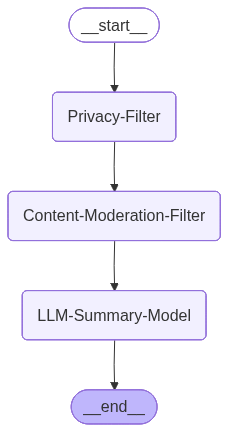

In [13]:
# Display the agent's execution graph as a Mermaid PNG image
display(Image(graph.get_graph().draw_mermaid_png()))

# ☠️ Final Outputs

- 🏁 Input – Raw human messages

- 🛡️ Privacy-Filter – Anonymizes PII and flags secrets.

- ☠️🔞 Content-Moderation – Replaces toxic/adult content with tags.

- 🧠 LLM-Summary – Generates concise, neutral summaries.

- 🧹 Tag Cleaning – Optionally removes system/obfuscation tags.

- 📜 Logging – Tracks all actions, replacements, and summaries.

- 💾 Final State – Combines sanitized messages, summaries, logs, and tag indices.

## ✅ All in one

In [14]:

# -------------------------
# Input state
# -------------------------
initial_state = {
    "messages": [
       HumanMessage(content=(
           "This world is so much unpredictable Albert is here. He is working in a office His email is albert99@test.com and phone is 01879020776, password=MySecret1234. This is absolutely terrible! I hate when people like you ruin everything. You are the worst and should just disappear! Now, Let's talk about Freed Oscar. His Friend has email freed.hamble2347@test.com and +1018790207. He is an a$$ and b1tch. Albert has SSN is 123-45-6789 under albert99@test.com. Always it accesses IP 10.100.10.11. Mike is always using f@ck, sh1t, d@mn. However, everything seems okay. Some fuzzy matches: fuk, shiit, daamn. Beware of it. That video contains explicit sexual content. This website has pornographic material. This link leads to explicit sexual images. They got the punishment. Everything is fine. I hate when people like you ruin everything. You are the worst, and bada$$. Goodbye."
        )),
    ],
    "conversation_id": str(uuid.uuid4()),
    "logs": [],
    "adult_tag_index": 1,
    "toxic_tag_index": 1,
}
# Print the content of the first message

print(f"🔍Original Message: {initial_state["messages"][0].content}\n")
# -------------------------
# Graph Config (Required for checkpointing)
# -------------------------
config = {
    "configurable": {
        #dynamic thread gen in every run
        "thread_id": str(uuid.uuid4()) # "thread_id":2 (fixed)
    }
}

# -------------------------
# Process messages one-by-one through graph
# -------------------------
sanitized_messages = []
logs = initial_state.get("logs", [])
adult_tag_index = initial_state.get("adult_tag_index", 1)
toxic_tag_index = initial_state.get("toxic_tag_index", 1)

for i, msg in enumerate(initial_state["messages"]):
    print(f"\n🔁 Processing Message {i + 1}...")

    temp_state = {
        "messages": [msg],
        "conversation_id": initial_state["conversation_id"],
        "logs": logs,  # Pass existing logs to accumulate
        "adult_tag_index": adult_tag_index,
        "toxic_tag_index": toxic_tag_index,
    }

    # Run the full LangGraph pipeline for this message
    result_state = graph.invoke(temp_state, config=config)

    # Store processed message
    #sanitized_messages.append(result_state["messages"][0])
    # --- Store all messages (sanitized + summary) ---
    sanitized_messages.extend(result_state["messages"])  # <- extend to include AIMessage

    # Update logs and tag indices for next iteration
    logs = result_state.get("logs", logs)
    adult_tag_index = result_state.get("adult_tag_index", adult_tag_index)
    toxic_tag_index = result_state.get("toxic_tag_index", toxic_tag_index)

# -------------------------
# Final combined state
# -------------------------
final_state = {
    "messages": sanitized_messages,
    "logs": logs,
    "conversation_id": initial_state["conversation_id"],
    "adult_tag_index": adult_tag_index,
    "toxic_tag_index": toxic_tag_index,
}

# -------------------------
# Print sanitized messages
# -------------------------
for i, msg in enumerate(final_state["messages"]):
    #print(f"\n=== ✅ Sanitized Message {i + 1} ===")
    #print(msg.content)

    # Human message = sanitized with tags
    if isinstance(msg, HumanMessage):
        print("🧹 Sanitized Message (with tags):")
        print(msg.content)

        # Clean tags for reference
        cleaned_text = clean_tags(msg.content)
        print("\n✨ Cleaned Message (tags removed):")
        print(cleaned_text)

    # AI message = summary
    elif isinstance(msg, AIMessage):
        print("📝 Summarized Output:")
        print(msg.content)


# -------------------------
# Print logs
# -------------------------
print("\n========================================================🧾 Log Reports ======================================================================================")
for log in final_state["logs"]:
    print(log)


🔍Original Message: This world is so much unpredictable Albert is here. He is working in a office His email is albert99@test.com and phone is 01879020776, password=MySecret1234. This is absolutely terrible! I hate when people like you ruin everything. You are the worst and should just disappear! Now, Let's talk about Freed Oscar. His Friend has email freed.hamble2347@test.com and +1018790207. He is an a$$ and b1tch. Albert has SSN is 123-45-6789 under albert99@test.com. Always it accesses IP 10.100.10.11. Mike is always using f@ck, sh1t, d@mn. However, everything seems okay. Some fuzzy matches: fuk, shiit, daamn. Beware of it. That video contains explicit sexual content. This website has pornographic material. This link leads to explicit sexual images. They got the punishment. Everything is fine. I hate when people like you ruin everything. You are the worst, and bada$$. Goodbye.


🔁 Processing Message 1...
✔ Download and installation successful
You can now load the package via spacy.lo

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



🧹 Sanitized Message (with tags):
This world is so much <Flagged> <PERSON> is here. He is working in a office His email is [TRACKER:EMAIL:4c92faf3dd48ce3b] and phone is [TRACKER:PHONE:631a4a5d2704019e], <Flagged> This is absolutely terrible! [txc-sen:1] Now, Let's talk about <PERSON>. His <PERSON> has email [TRACKER:EMAIL:96b928a338e6dbd1] and <Flagged> He is an [OBF:1] and [OBF:2]. <PERSON> has SSN is <Flagged> under [TRACKER:EMAIL:4c92faf3dd48ce3b]. Always it accesses IP <Flagged> <PERSON> is always using [OBF:3], <Flagged> d@mn. However, everything seems okay. Some fuzzy matches: [OBF:4], [OBF:5], [OBF:6]. [adult-sen:1] [adult-sen:2] [adult-sen:3] [adult-sen:4] They got the <Flagged> <Flagged> is fine. [txc-sen:2] Goodbye.

✨ Cleaned Message (tags removed):
("This world is so much <PERSON> is here. He is working in a office His email is and phone is , This is absolutely terrible! Now, Let's talk about <PERSON>. His <PERSON> has email and He is an and . <PERSON> has SSN is under . Al

## 1. ✅ Email and Phone Number

In [15]:

# -------------------------
# Input state
# -------------------------
initial_state = {
    "messages": [
       HumanMessage(content=(
           "Today, we have a meeting. Albert is here. He is working in a office His email is albert99@test.com and phone is 01879020776. His Friend has email freed.hamble2347@test.com and +1018790207.Goodbye"
        )),
    ],
    "conversation_id": str(uuid.uuid4()),
    "logs": [],
    "adult_tag_index": 1,
    "toxic_tag_index": 1,
}

# Print the content of the first message

print(f"🔍Original Message: {initial_state["messages"][0].content}\n")

# -------------------------
# Graph Config (Required for checkpointing)
# -------------------------
config = {
    "configurable": {
        #dynamic thread gen in every run
        "thread_id": str(uuid.uuid4()) # "thread_id":2 (fixed)
    }
}

# -------------------------
# Process messages one-by-one through graph
# -------------------------
sanitized_messages = []
logs = initial_state.get("logs", [])
adult_tag_index = initial_state.get("adult_tag_index", 1)
toxic_tag_index = initial_state.get("toxic_tag_index", 1)

for i, msg in enumerate(initial_state["messages"]):
    print(f"\n🔁 Processing Message {i + 1}...")

    temp_state = {
        "messages": [msg],
        "conversation_id": initial_state["conversation_id"],
        "logs": logs,  # Pass existing logs to accumulate
        "adult_tag_index": adult_tag_index,
        "toxic_tag_index": toxic_tag_index,
    }

    # Run the full LangGraph pipeline for this message
    result_state = graph.invoke(temp_state, config=config)

    # Store processed message
    #sanitized_messages.append(result_state["messages"][0])
    # --- Store all messages (sanitized + summary) ---
    sanitized_messages.extend(result_state["messages"])  # <- extend to include AIMessage

    # Update logs and tag indices for next iteration
    logs = result_state.get("logs", logs)
    adult_tag_index = result_state.get("adult_tag_index", adult_tag_index)
    toxic_tag_index = result_state.get("toxic_tag_index", toxic_tag_index)

# -------------------------
# Final combined state
# -------------------------
final_state = {
    "messages": sanitized_messages,
    "logs": logs,
    "conversation_id": initial_state["conversation_id"],
    "adult_tag_index": adult_tag_index,
    "toxic_tag_index": toxic_tag_index,
}

# -------------------------
# Print sanitized messages
# -------------------------
for i, msg in enumerate(final_state["messages"]):
    #print(f"\n=== ✅ Sanitized Message {i + 1} ===")
    #print(msg.content)

    # Human message = sanitized with tags
    if isinstance(msg, HumanMessage):
        print("🧹 Sanitized Message (with tags):")
        print(msg.content)

        # Clean tags for reference
        cleaned_text = clean_tags(msg.content)
        print("\n✨ Cleaned Message (tags removed):")
        print(cleaned_text)

    # AI message = summary
    elif isinstance(msg, AIMessage):
        print("📝 Summarized Output:")
        print(msg.content)


# -------------------------
# Print logs
# -------------------------
print("\n========================================================🧾 Log Reports ======================================================================================")
for log in final_state["logs"]:
    print(log)


🔍Original Message: Today, we have a meeting. Albert is here. He is working in a office His email is albert99@test.com and phone is 01879020776. His Friend has email freed.hamble2347@test.com and +1018790207.Goodbye


🔁 Processing Message 1...

🧹 Sanitized Message (with tags):
<Flagged> we have a meeting. <PERSON> is here. He is working in a office His email is [TRACKER:EMAIL:4c92faf3dd48ce3b] and phone is [TRACKER:PHONE:631a4a5d2704019e]. His <PERSON> has email [TRACKER:EMAIL:96b928a338e6dbd1] and <Flagged>

✨ Cleaned Message (tags removed):
('we have a meeting. <PERSON> is here. He is working in a office His email is and phone is . His <PERSON> has email and', ['Tracker tag: [TRACKER:EMAIL:4c92faf3dd48ce3b]', 'Tracker tag: [TRACKER:PHONE:631a4a5d2704019e]', 'Tracker tag: [TRACKER:EMAIL:96b928a338e6dbd1]', 'Flagged marker: <Flagged>', 'Flagged marker: <Flagged>'])
📝 Summarized Output:
A meeting is scheduled; a person is present and works in an office. Contact details for the individual

## 2. ✅ Preventing Slang

In [16]:

# -------------------------
# Input state
# -------------------------
initial_state = {
    "messages": [
       HumanMessage(content=(
           "Some good people are present here.He is an a$$ and b1tch. Mike is always using f@ck, sh1t, d@mn. However, everything seems okay. Some fuzzy matches: fuk, shiit, daamn. I hate when people like you ruin."
        )),
    ],
    "conversation_id": str(uuid.uuid4()),
    "logs": [],
    "adult_tag_index": 1,
    "toxic_tag_index": 1,
}

# Print the content of the first message

print(f"🔍Original Message: {initial_state["messages"][0].content}\n")

# -------------------------
# Graph Config (Required for checkpointing)
# -------------------------
config = {
    "configurable": {
        #dynamic thread gen in every run
        "thread_id": str(uuid.uuid4()) # "thread_id":2 (fixed)
    }
}

# -------------------------
# Process messages one-by-one through graph
# -------------------------
sanitized_messages = []
logs = initial_state.get("logs", [])
adult_tag_index = initial_state.get("adult_tag_index", 1)
toxic_tag_index = initial_state.get("toxic_tag_index", 1)

for i, msg in enumerate(initial_state["messages"]):
    print(f"\n🔁 Processing Message {i + 1}...")

    temp_state = {
        "messages": [msg],
        "conversation_id": initial_state["conversation_id"],
        "logs": logs,  # Pass existing logs to accumulate
        "adult_tag_index": adult_tag_index,
        "toxic_tag_index": toxic_tag_index,
    }

    # Run the full LangGraph pipeline for this message
    result_state = graph.invoke(temp_state, config=config)

    # Store processed message
    #sanitized_messages.append(result_state["messages"][0])
    # --- Store all messages (sanitized + summary) ---
    sanitized_messages.extend(result_state["messages"])  # <- extend to include AIMessage

    # Update logs and tag indices for next iteration
    logs = result_state.get("logs", logs)
    adult_tag_index = result_state.get("adult_tag_index", adult_tag_index)
    toxic_tag_index = result_state.get("toxic_tag_index", toxic_tag_index)

# -------------------------
# Final combined state
# -------------------------
final_state = {
    "messages": sanitized_messages,
    "logs": logs,
    "conversation_id": initial_state["conversation_id"],
    "adult_tag_index": adult_tag_index,
    "toxic_tag_index": toxic_tag_index,
}

# -------------------------
# Print sanitized messages
# -------------------------
for i, msg in enumerate(final_state["messages"]):
    #print(f"\n=== ✅ Sanitized Message {i + 1} ===")
    #print(msg.content)

    # Human message = sanitized with tags
    if isinstance(msg, HumanMessage):
        print("🧹 Sanitized Message (with tags):")
        print(msg.content)

        # Clean tags for reference
        cleaned_text = clean_tags(msg.content)
        print("\n✨ Cleaned Message (tags removed):")
        print(cleaned_text)

    # AI message = summary
    elif isinstance(msg, AIMessage):
        print("📝 Summarized Output:")
        print(msg.content)


# -------------------------
# Print logs
# -------------------------
print("\n========================================================🧾 Log Reports ======================================================================================")
for log in final_state["logs"]:
    print(log)


🔍Original Message: Some good people are present here.He is an a$$ and b1tch. Mike is always using f@ck, sh1t, d@mn. However, everything seems okay. Some fuzzy matches: fuk, shiit, daamn. I hate when people like you ruin.


🔁 Processing Message 1...

🧹 Sanitized Message (with tags):
Some good people are present here.He is an [OBF:1] and [OBF:2]. <PERSON> is always using [OBF:3], <Flagged> d@mn. However, everything seems okay. Some fuzzy matches: [OBF:4], [OBF:5], [OBF:6]. [txc-sen:1]

✨ Cleaned Message (tags removed):
('Some good people are present here.He is an and . <PERSON> is always using , d@mn. However, everything seems okay. Some fuzzy matches: , , .', ['Obfuscation tag: [OBF:1]', 'Obfuscation tag: [OBF:2]', 'Obfuscation tag: [OBF:3]', 'Obfuscation tag: [OBF:4]', 'Obfuscation tag: [OBF:5]', 'Obfuscation tag: [OBF:6]', 'Flagged marker: <Flagged>', 'Toxic sentence tag: [txc-sen:1]'])
📝 Summarized Output:
The note observes that good people are present, mentions a person who frequent

## 3. ✅ Preventing Adult Content

In [17]:

# -------------------------
# Input state
# -------------------------
initial_state = {
    "messages": [
       HumanMessage(content=(
           "That video contains explicit sexual content. This website has pornographic material. This link leads to explicit sexual images. They got the punishment. Everything is fine."
       )),
    ],
    "conversation_id": str(uuid.uuid4()),
    "logs": [],
    "adult_tag_index": 1,
    "toxic_tag_index": 1,
}

# Print the content of the first message

print(f"🔍Original Message: {initial_state["messages"][0].content}\n")

# -------------------------
# Graph Config (Required for checkpointing)
# -------------------------
config = {
    "configurable": {
        #dynamic thread gen in every run
        "thread_id": str(uuid.uuid4()) # "thread_id":2 (fixed)
    }
}

# -------------------------
# Process messages one-by-one through graph
# -------------------------
sanitized_messages = []
logs = initial_state.get("logs", [])
adult_tag_index = initial_state.get("adult_tag_index", 1)
toxic_tag_index = initial_state.get("toxic_tag_index", 1)

for i, msg in enumerate(initial_state["messages"]):
    print(f"\n🔁 Processing Message {i + 1}...")

    temp_state = {
        "messages": [msg],
        "conversation_id": initial_state["conversation_id"],
        "logs": logs,  # Pass existing logs to accumulate
        "adult_tag_index": adult_tag_index,
        "toxic_tag_index": toxic_tag_index,
    }

    # Run the full LangGraph pipeline for this message
    result_state = graph.invoke(temp_state, config=config)

    # Store processed message
    #sanitized_messages.append(result_state["messages"][0])
    # --- Store all messages (sanitized + summary) ---
    sanitized_messages.extend(result_state["messages"])  # <- extend to include AIMessage

    # Update logs and tag indices for next iteration
    logs = result_state.get("logs", logs)
    adult_tag_index = result_state.get("adult_tag_index", adult_tag_index)
    toxic_tag_index = result_state.get("toxic_tag_index", toxic_tag_index)

# -------------------------
# Final combined state
# -------------------------
final_state = {
    "messages": sanitized_messages,
    "logs": logs,
    "conversation_id": initial_state["conversation_id"],
    "adult_tag_index": adult_tag_index,
    "toxic_tag_index": toxic_tag_index,
}

# -------------------------
# Print sanitized messages
# -------------------------
for i, msg in enumerate(final_state["messages"]):
    #print(f"\n=== ✅ Sanitized Message {i + 1} ===")
    #print(msg.content)

    # Human message = sanitized with tags
    if isinstance(msg, HumanMessage):
        print("🧹 Sanitized Message (with tags):")
        print(msg.content)

        # Clean tags for reference
        cleaned_text = clean_tags(msg.content)
        print("\n✨ Cleaned Message (tags removed):")
        print(cleaned_text)

    # AI message = summary
    elif isinstance(msg, AIMessage):
        print("📝 Summarized Output:")
        print(msg.content)


# -------------------------
# Print logs
# -------------------------
print("\n========================================================🧾 Log Reports ======================================================================================")
for log in final_state["logs"]:
    print(log)


🔍Original Message: That video contains explicit sexual content. This website has pornographic material. This link leads to explicit sexual images. They got the punishment. Everything is fine.


🔁 Processing Message 1...

🧹 Sanitized Message (with tags):
[adult-sen:1] [adult-sen:2] [adult-sen:3] They got the <Flagged> <Flagged> is fine.

✨ Cleaned Message (tags removed):
('They got the is fine.', ['Flagged marker: <Flagged>', 'Flagged marker: <Flagged>', 'Adult sentence tag: [adult-sen:1]', 'Adult sentence tag: [adult-sen:2]', 'Adult sentence tag: [adult-sen:3]'])
📝 Summarized Output:
They received it and confirmed that everything is fine.

========================================================🧾 Log Reports ======================================================================================
[privacy_filter_pipeline_mode] -> executed: high_entropy_secrets
[adult_sentence_filter_node] | Removed [adult-sen:1] -> 'That video contains explicit sexual content.' (score: 0.53)
[adult_senten

## 4. ✅ Normal Sentence

In [18]:

# -------------------------
# Input state
# -------------------------
initial_state = {
    "messages": [
       HumanMessage(content=("Today is a fantastic day. Wind is blowing outside. Everybody is enjoying their time."
       )),

    ],
    "conversation_id": str(uuid.uuid4()),
    "logs": [],
    "adult_tag_index": 1,
    "toxic_tag_index": 1,
}

# Print the content of the first message

print(f"🔍Original Message: {initial_state["messages"][0].content}\n")

# -------------------------
# Graph Config (Required for checkpointing)
# -------------------------
config = {
    "configurable": {
        #dynamic thread gen in every run
        "thread_id": str(uuid.uuid4()) # "thread_id":2 (fixed)
    }
}

# -------------------------
# Process messages one-by-one through graph
# -------------------------
sanitized_messages = []
logs = initial_state.get("logs", [])
adult_tag_index = initial_state.get("adult_tag_index", 1)
toxic_tag_index = initial_state.get("toxic_tag_index", 1)

for i, msg in enumerate(initial_state["messages"]):
    print(f"\n🔁 Processing Message {i + 1}...")

    temp_state = {
        "messages": [msg],
        "conversation_id": initial_state["conversation_id"],
        "logs": logs,  # Pass existing logs to accumulate
        "adult_tag_index": adult_tag_index,
        "toxic_tag_index": toxic_tag_index,
    }

    # Run the full LangGraph pipeline for this message
    result_state = graph.invoke(temp_state, config=config)

    # Store processed message
    #sanitized_messages.append(result_state["messages"][0])
    # --- Store all messages (sanitized + summary) ---
    sanitized_messages.extend(result_state["messages"])  # <- extend to include AIMessage

    # Update logs and tag indices for next iteration
    logs = result_state.get("logs", logs)
    adult_tag_index = result_state.get("adult_tag_index", adult_tag_index)
    toxic_tag_index = result_state.get("toxic_tag_index", toxic_tag_index)

# -------------------------
# Final combined state
# -------------------------
final_state = {
    "messages": sanitized_messages,
    "logs": logs,
    "conversation_id": initial_state["conversation_id"],
    "adult_tag_index": adult_tag_index,
    "toxic_tag_index": toxic_tag_index,
}

# -------------------------
# Print sanitized messages
# -------------------------
for i, msg in enumerate(final_state["messages"]):
    #print(f"\n=== ✅ Sanitized Message {i + 1} ===")
    #print(msg.content)

    # Human message = sanitized with tags
    if isinstance(msg, HumanMessage):
        print("🧹 Sanitized Message (with tags):")
        print(msg.content)

        # Clean tags for reference
        cleaned_text = clean_tags(msg.content)
        print("\n✨ Cleaned Message (tags removed):")
        print(cleaned_text)

    # AI message = summary
    elif isinstance(msg, AIMessage):
        print("📝 Summarized Output:")
        print(msg.content)


# -------------------------
# Print logs
# -------------------------
print("\n========================================================🧾 Log Reports ======================================================================================")
for log in final_state["logs"]:
    print(log)


🔍Original Message: Today is a fantastic day. Wind is blowing outside. Everybody is enjoying their time.


🔁 Processing Message 1...

🧹 Sanitized Message (with tags):
<DATE_TIME> is <Flagged> Wind is blowing outside. Everybody is enjoying their time.

✨ Cleaned Message (tags removed):
('<DATE_TIME> is Wind is blowing outside. Everybody is enjoying their time.', ['Flagged marker: <Flagged>'])
📝 Summarized Output:
At the specified time, wind is blowing outside and people are enjoying themselves.

========================================================🧾 Log Reports ======================================================================================
[privacy_filter_pipeline_mode] -> presidio_anonymizer executed: date_time
[privacy_filter_pipeline_mode] -> executed: date_time, high_entropy_secrets
[summarization_node] -> cleaned tags from message.
[summarization_node] -> removed tags: ['Flagged marker: <Flagged>']
[summarization_node] -> summary generated successfully.


# 📛 Output Testing without Lang Graph

## 📌 Single Function


In [19]:
# -------------------------
# Input messages
# -------------------------
state = {
    "messages": [
        HumanMessage(
            content="This is John Wishtel, my email is john99@test.com.en, my phone is 018790207, password=MySecret1234. This is absolutely terrible! I hate when people like you ruin everything. You are the worst and should just disappear! I am fine"

        ),
        HumanMessage(
            content="His name is Freed, my email is freed.hamble2347@test.com, my phone is 0198689078, pass: Iut12349$, and my API key is abLM-1234-efgh-5678. And he is bada$$. Check out this nude scene from the movie"
        ),
        HumanMessage(
            content="John  is here, his email is john99@test.com.en, my phone is 018790207,And he is a$$ and b1tch. His SSN is 123-45-6789 and IP: 10.100.10.11. He said b1tch and f@ck multiple times. That sh1t was crazy, d@mn it! Look at this word: a$$, and bıtch (with Cyrillic i) Some fuzzy matches: fuk, shiit, daamn. Normal words: hello, world, test. Tokens and emails should remain: john99@test.com, phone: 018790207."),
        HumanMessage(
            content="System is fine. That video contains explicit sexual content. This website has pornographic material. You are asshole. Everything is fine. This link leads to explicit sexual images. Weather is fine"
        ),
        ],
    "conversation_id": str(uuid.uuid4()),
    "logs": []
}

# -------------------------
# Apply filter to each message individually
# -------------------------
sanitized_messages = []
for i, msg in enumerate(state["messages"]):
    # create a temporary state for this single message
    temp_state = {"messages": [msg], "logs": state.get("logs", [])}
    temp_state =PrivacyFilter().privacy_pipeline_filter_mode(temp_state)
    sanitized_messages.append(temp_state["messages"][0])  # keep the sanitized message
    state["logs"] = temp_state.get("logs", [])
    print(f"\n=== Sanitized Message {i+1} ===")
    print(temp_state["messages"][0].content)

# Update the state with all sanitized messages
state["messages"] = sanitized_messages

# -------------------------
# Print logs
# -------------------------
print("\n=== Logs ===")
for log in state.get("logs", []):
    print(log)



=== Sanitized Message 1 ===
This is <PERSON>, my email is [TRACKER:EMAIL:eaf9dcd4c3f57e1e], my phone is [TRACKER:PHONE:42045c443d0f3da5], <Flagged> This is absolutely terrible! I hate when people like you ruin <Flagged> You are the worst and should just disappear! I am fine

=== Sanitized Message 2 ===
His name is Freed, my email is [TRACKER:EMAIL:96b928a338e6dbd1], my phone is [TRACKER:PHONE:d7983a4e16cc4ee9], pass: <Flagged> and my API key is <Flagged> And he is bada$$. Check out this nude scene from the movie

=== Sanitized Message 3 ===
<Flagged> here, his email is [TRACKER:EMAIL:eaf9dcd4c3f57e1e], my phone is [TRACKER:PHONE:42045c443d0f3da5],And he is a$$ and b1tch. His SSN is <Flagged> and IP: <Flagged> He said b1tch and f@ck multiple times. That <NRP>t was crazy, d@mn it! Look at this word: a$$, and bıtch (with Cyrillic i) Some fuzzy matches: fuk, shiit, daamn. Normal words: hello, world, test. Tokens and emails should remain: [TRACKER:EMAIL:17452fe34ee19a55], phone: [TRACKER:P

## 📌 Test Execution with all nodes without LangGraph

In [ ]:
# -------------------------
# Input messages
# -------------------------
state = {
    "messages": [
        HumanMessage(content="This is John Wishtel, my email is john99@test.com, my phone is 01879020776, password=MySecret1234. This is absolutely terrible! I hate when people like you ruin everything. You are the worst and should just disappear! I am fine"),
        HumanMessage(content="His name is Freed, my email is freed.hamble2347@test.com, my phone is 0198689078, pass: Iut12349, and my API key is abLM-1234-efgh-5678. And he is bada$$. Check out this nude scene from the movie"),
        HumanMessage(content="John  is here, his email is john99@test.com, my phone is 018790207,And he is a$$ and b1tch. His SSN is 123-45-6789 and IP: 10.100.10.11. He said b1tch and f@ck multiple times. That sh1t was crazy, d@mn it! Look at this word: a$$, and bıtch (with Cyrillic i) Some fuzzy matches: fuk, shiit, daamn. Normal words: hello, world, test. Tokens and emails should remain: john99@test.com, phone: 018790207."),
        HumanMessage(content="System is fine. That video contains explicit sexual content. This website has pornographic material. You are asshole. Everything is fine. This link leads to explicit sexual images. Weather is fine"),
        HumanMessage(
            content="System is fine. That video contains explicit sexual content. This website has pornographic material. You are asshole. Everything is fine. This link leads to explicit sexual images. Weather is fine"
        ),
        HumanMessage(content="This is John Wishtel.This is absolutely terrible! I hate when people like you ruin everything. You are the worst, and bada$$ and should just disappear! I am Fine"),

        ],
    "conversation_id": str(uuid.uuid4()),
    "logs": []
}

# -------------------------
# Global counters
# -------------------------
global_adult_tag = 1
global_toxic_tag = 1
logs = []

# -------------------------
# Apply all filters sequentially
# -------------------------
sanitized_messages = []

for i, msg in enumerate(state["messages"]):
    temp_state = {"messages": [msg], "logs": logs, "adult_tag_index": global_adult_tag, "toxic_tag_index": global_toxic_tag}

    # --- Privacy Filter Node ---
    temp_state = privacy_pipeline_filter_node(temp_state)

    # --- Presidio Node ---
    #temp_state = presidio_filter_node(temp_state, analyzer=analyzer, anonymizer=anonymizer)

    # --- Obfuscation Node ---
    temp_state = obfuscation_filter_node(temp_state)

    # --- Toxic Sentence Node ---
    temp_state = toxic_sentence_filter_node(temp_state)

    # --- Adult Sentence Node ---
    temp_state = adult_sentence_filter_node(temp_state)

    # --- Tool/LLM Node ---
    temp_state = tool_calling_llm(temp_state)

    # Collect sanitized message
    sanitized_messages.append(temp_state["messages"][0])

    # Update global logs and counters
    logs = temp_state.get("logs", [])
    global_adult_tag = temp_state.get("adult_tag_index", global_adult_tag)
    global_toxic_tag = temp_state.get("toxic_tag_index", global_toxic_tag)

    print(f"\n=== Sanitized Message {i+1} ===")
    print(temp_state["messages"][0].content)

# Update state
state["messages"] = sanitized_messages
state["logs"] = logs

# -------------------------
# Print final logs
# -------------------------
print("\n=== Logs ===")
for log in logs:
    print(log)
